In [1]:
import datetime 
import matplotlib
import matplotlib.dates as mdates 
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import MySQLdb

%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0)
font = {'size': 20}
matplotlib.rc('font', **font)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install pymysql


### Create a MySQL query class

In [3]:
#https://github.com/nestordeharo/mysql-python-class/blob/master/mysql_python.py
class mysql_local():
    '''
        Hard-coded local instance for this notebook using read-only user.
        First instantiate class, .connect() and .query(query_str)
    '''
    def __init__(self):
        self.host = 'localhost'
        self.user = 'root'
        self.password = 'root'
        self.database = 'babs'
        self.port = 3301
    def connect(self):
        self.db = MySQLdb.connect(self.host, self.user, self.password, self.database, self.port)
    def query(self, query):
        self.cursor = self.db.cursor()
        self.cursor.execute(query)
        results = self.cursor.fetchall()
        return results
    def inspect(self,table):
        '''
        This displays an HTML table (using a pandas DataFrame display)
        with the table header and 1 sample entry
        '''
        describeme = db.query('describe %s;' % table)
        sample_entry = db.query('select * from %s limit 1;' % table)[0]
        header_names = [x[0] for x in describeme]
        df = pd.DataFrame([sample_entry],columns=header_names)
        display(df)

### Custom Plotting Functions

In [4]:
def SetLegend(ax,location='upper center'):
    leg = ax.legend(loc=location,numpoints=1,fontsize=12,shadow=True); 
    leg.get_frame().set_facecolor('white')
    
def FormatYAxisThousands(ax):
    comma_formatter_func = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    ax.get_yaxis().set_major_formatter(comma_formatter_func)
    
def OffsetDate(date,delta_time=5):
    return date + datetime.timedelta(delta_time)

def MoneyFormat(x, pos):
    '''
        The two args are the value and tick position
    '''
    return '\$%2.1fM' % (x*1e-6)

def PlotMarkers(marker_dict,ax=None,yloc=None,col='k',fontsize=12):
    '''
        Plots vertical dashed lines at specified locations with labels
        'marker_dict' is a dictionary where the keys are the x-locations and the
        values are the marker labels
    '''
    assert isinstance(marker_dict,dict),"ERROR: Input 'markers' must be a dictionary."
    # Inputs
    ax = ax or plt.gca()
    yloc = yloc or np.mean(ax.get_ylim())
    # Add time markers
    for x in marker_dict.keys():
        ax.plot((x,x),ax.get_ylim(),'--',color=col)
        ax.text(OffsetDate(x,5),yloc,marker_dict[x],color=col,fontsize=fontsize)

def RemoveBorder(axes=None, top=False, right=False, left=True, bottom=True):
    '''
        Removes borders for a cleaner-looking plot
    '''
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom) 
    # turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    # now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

### Cell timing function tic-toc

In [5]:
import time
class tictoc():
    '''
    This provides similar functionality to MATLAB's tic toc timing.
    Create an object t = tictoc()
    then t.tic() starts timer, t.toc() ends it and prints the delta time 
    It supports multiple t.toc() calls to time different stages.
    '''
    def __init__(self):
        self.time1 = None
    def tic(self):
        self.time1 = time.time()
    def toc(self):
        self.time2 = time.time()
        delta_seconds = self.time2 - self.time1
        if delta_seconds < 60:
            print 'Time elapsed: %3.2f sec' % delta_seconds
        else:
            print 'Time elapsed: %3.1f min' % delta_seconds/60.
            
t = tictoc()

## Connect to local MySQL

In [6]:
db = mysql_local()
db.connect()

In [7]:
db.inspect('trip_data')

,trip_id,duration_sec,start_date,start_station,start_terminal,end_date,end_station,end_terminal,bike_num,subscription_type,trip_cost,zip_code
0,432947,569,2014-09-01 00:05:00,South Van Ness at Market,66,2014-09-01 00:15:00,5th at Howard,57,318,Customer,0,32


In [8]:
db.inspect('station_data')

,station_id,name,latitude,longitude,dockcount,landmark,landmark_code,installation
0,2,San Jose Diridon Caltrain Station,37.329731,-121.901779,27,San Jose,SJ,8/6/2013


In [9]:
db.inspect('rebalancing_data')

,entry_id,station_id,bikes_available,docks_available,time
0,1,2,15,12,2014-09-01 00:00:03


In [10]:
db.inspect('customer_data');

,date,total_customers,san_francisco,redwood_city,palo_alto,mountain_view,san_jose
0,2014-07-01,25895,22070,173,941,872,1839


In [11]:
db.inspect('weather_data');

,date,zip_code,city_code,max_temperature_F,mean_temperature_F,min_temperature_F,max_dew_point_F,mean_dew_point_F,min_dew_point_F,max_humidity,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_In,cloud_cover,events,wind_dir_degrees
0,2014-09-01,94041,MV,85,73,60,60,58,53,84,...,10,10,10,17,5,21,0.0,0,NaN,342


# Data Mining Portion


### Query

In [156]:
t.tic()
query_str = "select date_format(start_date,'%d/%m/%Y') as start_date_binned_day, \
            count(*), \
            sum(duration_sec), \
            subscription_type \
            from trip_data \
            group by start_date_binned_day, subscription_type \
            order by start_date;"

# [0] start_date_binned_day
# [1] count
# [2] sum_duration_sec
# [3] subscription_type

results = db.query(query_str);
t.toc()
xaxis_days = [datetime.datetime.strptime(x[0], '%d/%m/%Y') for x in results if x[3]=='Subscriber']

trips_subscriber = [x[1] for x in results if x[3]=='Subscriber']
hours_ridden_subscriber = [float(x[2])/3600 for x in results if x[3]=='Subscriber']

trips_customer = [x[1] for x in results if x[3]=='Customer']
hours_ridden_customer = [float(x[2])/3600 for x in results if x[3]=='Customer']

Time elapsed: 0.41 sec


### Plot daily usage (trips, time spent)


In [157]:
max(hours_ridden_customer) #Outlier Data

4908.426111111111

In [153]:
hours_ridden_customer = [490.426 if x==4908.426111111111 else x for x in hours_ridden_customer]

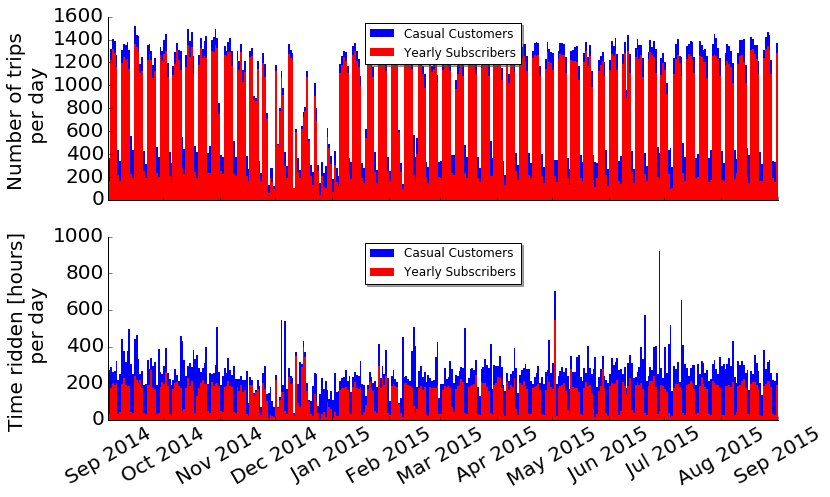

In [154]:
def PlotHolidays(ax,col='k'):
    # These are dates of interest for marking in plot
    marker = []
    marker.append(datetime.datetime(2015,9,1)) # Sep 1st? Why?
    # Add time markers
    ax.plot((marker1,marker1),ax.get_ylim(),'--',color=col)
    ax.text(OffsetDate(marker1),yloc,'BABS starts',color=col,fontsize=12)

w = 1
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True)
ax[0].bar(xaxis_days,trips_customer,color='b',bottom=trips_subscriber,width=w,label='Casual Customers',linewidth=0)
ax[0].bar(xaxis_days,trips_subscriber,color='r',width=w,label='Yearly Subscribers',linewidth=0)
# ax[0].grid(1) # turn on grid
ax[0].set_ylabel('Number of trips \n per day')
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
RemoveBorder(ax[0])
SetLegend(ax[0])

ax[1].bar(xaxis_days,hours_ridden_customer,color='b',bottom=hours_ridden_subscriber,width=w,label='Casual Customers',linewidth=0)
ax[1].bar(xaxis_days,hours_ridden_subscriber,color='r',width=w,label='Yearly Subscribers',linewidth=0)
# ax[1].grid(1) # turn on grid
ax[1].set_ylabel('Time ridden [hours] \n per day')
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
RemoveBorder(ax[1])
SetLegend(ax[1])

fig.autofmt_xdate(ha='center')
plt.show()

## User numbers


### Query

In [15]:
t.tic()
query_str_subscribers = "select date,total_subscribers from subscriber_data order by date;"
results_subscribers = db.query(query_str_subscribers)

query_str_customers = "select date,total_customers from customer_data order by date;"
results_customers = db.query(query_str_customers)
t.toc()

# [0] date
# [1] total

xaxis_days_subscribers = [x[0] for x in results_subscribers]
total_subscribers = [x[1] for x in results_subscribers]

xaxis_days_customers = [x[0] for x in results_customers]
total_customers = [x[1] for x in results_customers]

Time elapsed: 0.01 sec


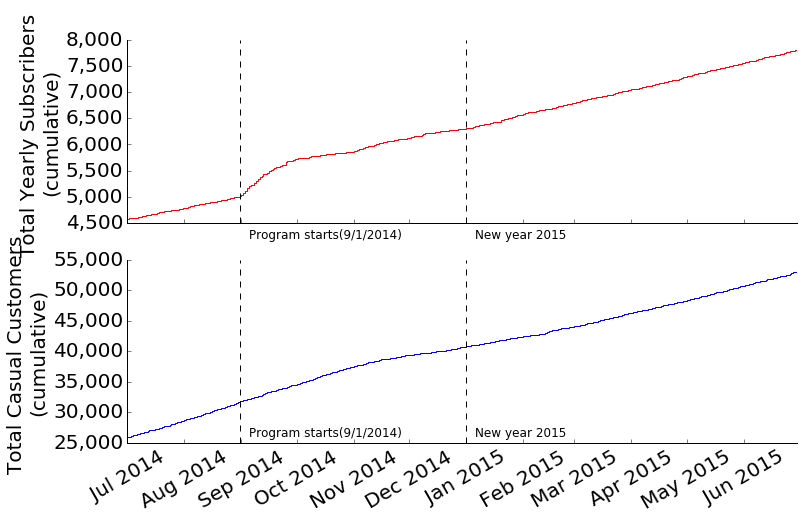

In [178]:
# These are dates of interest for marking in plot    
markers = dict()
markers[datetime.datetime(2014,8,31)] = 'Program starts(9/1/2014)'; # Program start
markers[datetime.datetime(2015,1,1)] = 'New year 2015'; # New Year's

# Plot Subscribers
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True)
ax[0].plot(xaxis_days_subscribers,total_subscribers,color='r',label='Subscribers',drawstyle='steps-post')
PlotMarkers(markers,ax=ax[0],yloc=4200)
# ax[0].grid(1) # turn on grid
ax[0].set_ylabel('Total Yearly Subscribers \n(cumulative)')
FormatYAxisThousands(ax[0])
RemoveBorder(ax[0])

# Plot Customers
ax[1].plot(xaxis_days_customers,total_customers,color='b',label='Customers',drawstyle='steps-post')
PlotMarkers(markers,ax=ax[1],yloc=26000)
# ax[1].grid(1) # turn on grid
ax[1].set_ylabel('Total Casual Customers \n(cumulative)')
FormatYAxisThousands(ax[1])
RemoveBorder(ax[1])
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(ha='center')
plt.show()

### Revenue

Since each subscription is worth $88, we can show this as revenue.
We can also estimate the overage charge revenue from 'Customers' (non-subscribers) since the overage cost is uniquely determined by the total time spent, which is data we have for each trip.

These are the 'Customer' overage charges:
 * \$9 (24-hour) or \$22 (3-day) initial charge
 * If trip [0-30] min, \$0
 * If trip [31-60] min, +\$4
 * Each additional 30 min, +\$7 up to \$150 total charge
 
There are almost no overage charges for 'Subscribers' so don't bother with those.

Despite the fact that we can exactly calculate the total overage cost, we don't know whether the customer purchased a 24-hour or 3-day pass. It would make sense for 24-hour passes to be much more popular than the 3-day counterparts (especially since you're not allowed to keep the bike for 3 days! That's just the length of the subscription). Therefore, let's assume all customers purchase a 24-hour pass. This will place a lower-bound on the total revenue from customers.

In [23]:
t.tic()
query_str = "select date_format(start_date,'%d/%m/%Y') as start_date_binned_day, \
                sum(trip_cost), \
                subscription_type \
                from trip_data \
                group by start_date_binned_day,subscription_type \
                order by start_date;"

results = db.query(query_str)
t.toc()

# [0] start_date_binned_day
# [1] sum_revenue
# [2] subscription_type

xaxis_days_overages = [datetime.datetime.strptime(x[0], '%d/%m/%Y') for x in results if x[2] == 'Customer']
per_day_overage_customers = [x[1] for x in results if x[2]=='Customer']
per_day_overage_subscribers = [x[1] for x in results if x[2]=='Subscriber']

Time elapsed: 0.37 sec


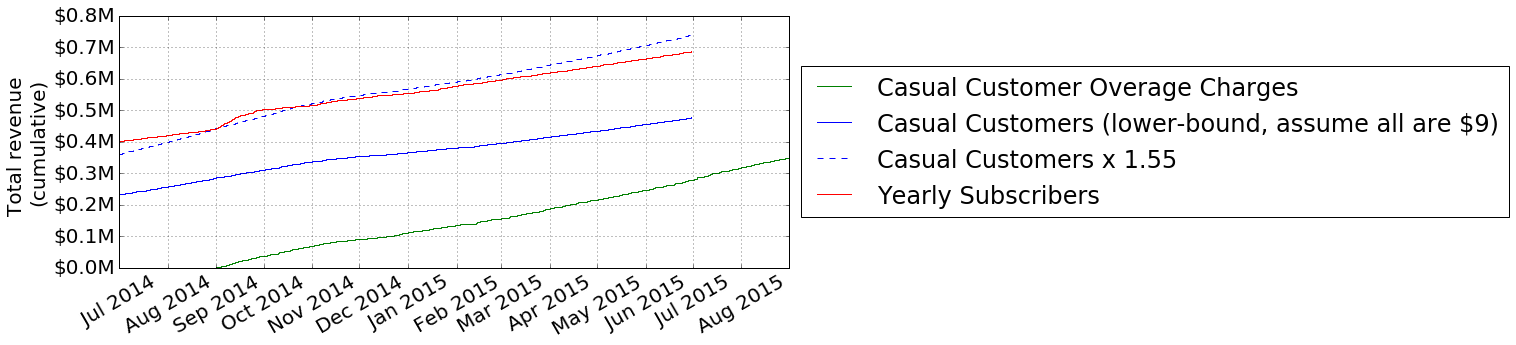

In [193]:
fig = plt.figure(figsize=(12.,5.));
ax = fig.gca()

# Plot customer revenue
ax.plot(xaxis_days_overages,np.cumsum(per_day_overage_customers),'-',color='g',label='Casual Customer Overage Charges',drawstyle='steps-post')
ax.plot(xaxis_days_customers,np.array(total_customers)*9,color='b',label='Casual Customers (lower-bound, assume all are \$9)',drawstyle='steps-post')
ax.plot(xaxis_days_customers,np.array(total_customers)*9*1.55,'--',color='b',label='Casual Customers x 1.55',drawstyle='steps-post')

# Plot subscriber revenue
# ax.plot(xaxis_days_overages,np.cumsum(per_day_overage_subscribers),'r--',label='Overages (Subscribers)',drawstyle='steps-post')
ax.plot(xaxis_days_subscribers,np.array(total_subscribers)*88,color='r',label='Yearly Subscribers',drawstyle='steps-post')

ax.grid(1) # turn on grid
ax.set_ylabel('Total revenue \n(cumulative)')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.yaxis.set_major_formatter(FuncFormatter(MoneyFormat))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate(ha='center')
plt.show()

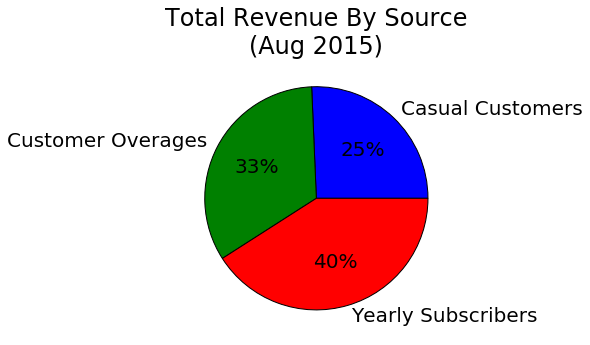

In [30]:
aug2015 = datetime.datetime(2014,8,14,0,0)
rev_overages = sum(per_day_overage_customers)
rev_customers = total_customers[xaxis_days_customers.index(aug2015)]*9
rev_subscribers = total_subscribers[xaxis_days_subscribers.index(aug2015)]*88

fig = plt.figure(figsize=(5.,5.))
plt.subplot(aspect=True)
plt.pie([rev_customers,rev_overages,rev_subscribers], labels=['Casual Customers','Customer Overages','Yearly Subscribers'], autopct=r'%i%%')
plt.title("Total Revenue By Source\n(Aug 2015)")
plt.show()

## Daily Rhythms

### Query


In [31]:
t.tic()
query_str_weekday = "select HOUR(start_date) as start_hour, \
            count(*), \
            subscription_type \
            from trip_data \
            where WEEKDAY(start_date) < 5 \
            group by start_hour, subscription_type;"

query_str_weekend = "select HOUR(start_date) as start_hour, \
            count(*), \
            subscription_type \
            from trip_data \
            where WEEKDAY(start_date) >= 5 \
            group by start_hour, subscription_type;"

# [0] start_hour
# [1] count
# [2] subscription_type

results_weekday = db.query(query_str_weekday)
results_weekend = db.query(query_str_weekend)
t.toc()

hour_of_weekday = [x[0] for x in results_weekday if x[2] == 'Subscriber']
count_subscriber_weekday = np.array([x[1] for x in results_weekday if x[2] == 'Subscriber'])
count_customer_weekday = np.array([x[1] for x in results_weekday if x[2] == 'Customer'])

count_subscriber_weekend = np.array([x[1] for x in results_weekend if x[2] == 'Subscriber'])
count_customer_weekend = np.array([x[1] for x in results_weekend if x[2] == 'Customer'])

# Overall normalization of trip counts
norm = float(sum(count_subscriber_weekday) + sum(count_customer_weekday) + sum(count_subscriber_weekend) + sum(count_customer_weekend))


cut_rush_hour1 = np.where((np.array(hour_of_weekday) >= 7) & (np.array(hour_of_weekday) < 10))
cut_rush_hour2 = np.where((np.array(hour_of_weekday) >= 16) & (np.array(hour_of_weekday) < 19))
total_rush_hour_fraction_subs = sum(count_subscriber_weekday[cut_rush_hour1]/norm) + sum(count_subscriber_weekday[cut_rush_hour2]/norm)
total_rush_hour_fraction_cust = sum(count_customer_weekday[cut_rush_hour1]/norm) + sum(count_customer_weekday[cut_rush_hour2]/norm)

total_rush_hour_percent = np.array(total_rush_hour_fraction_subs+total_rush_hour_fraction_cust)*100

Time elapsed: 0.43 sec


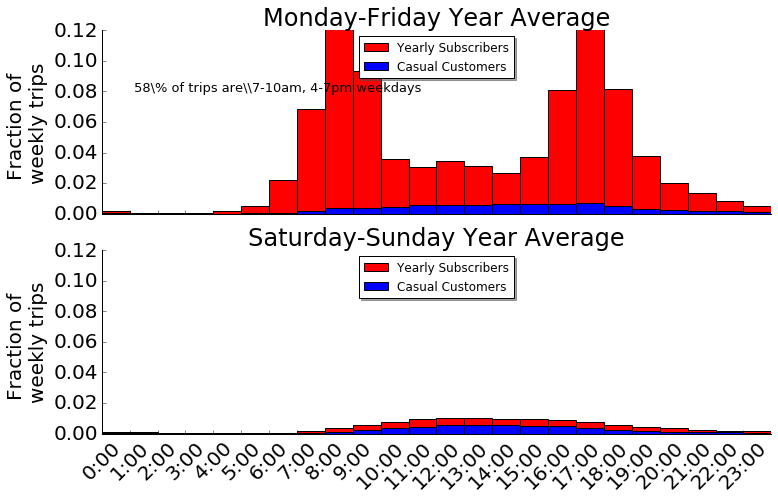

In [32]:
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True)
ax[0].bar(hour_of_weekday,count_subscriber_weekday/norm,color='r',bottom=count_customer_weekday/norm,width=1,label='Yearly Subscribers')
ax[0].bar(hour_of_weekday,count_customer_weekday/norm,color='b',width=1,label='Casual Customers')
ax[0].set_ylabel('Fraction of \nweekly trips')
# ax[0].grid(1) # turn on grid
ax[0].set_title('Monday-Friday Year Average')
ax[0].set_ylim([0,0.12])
ax[0].text(1,0.08,r'%3.0f\%% of trips are\\7-10am, 4-7pm weekdays' % total_rush_hour_percent, fontsize=13)
RemoveBorder(ax[0])
SetLegend(ax[0])

ax[1].bar(hour_of_weekday,count_subscriber_weekend/norm,color='r',bottom=count_customer_weekend/norm,width=1,label='Yearly Subscribers')
ax[1].bar(hour_of_weekday,count_customer_weekend/norm,color='b',width=1,label='Casual Customers')
ax[1].set_ylabel('Fraction of \nweekly trips')
ax[1].set_title('Saturday-Sunday Year Average')

ax[1].set_xticks(np.linspace(0,23,24))
ax[1].set_xticklabels(['%d:00' % x for x in hour_of_weekday])
# ax[1].grid(1) # turn on grid
ax[1].set_ylim([0,0.12])
ax[1].set_xlim([0,24])
RemoveBorder(ax[1])
SetLegend(ax[1])

fig.autofmt_xdate(ha='center',rotation=45)
plt.show()

## Distribution of Trip Times

In [33]:
t.tic()
query_duration = "select duration_sec, \
                    subscription_type \
                    from trip_data;"

# [0] duration_sec
# [1] customer_type

results_duration = db.query(query_duration)
duration_sec_subscribers = np.array([x[0] for x in results_duration if x[1] == 'Subscriber'])
duration_sec_customers = np.array([x[0] for x in results_duration if x[1] == 'Customer'])
t.toc()

Time elapsed: 0.59 sec


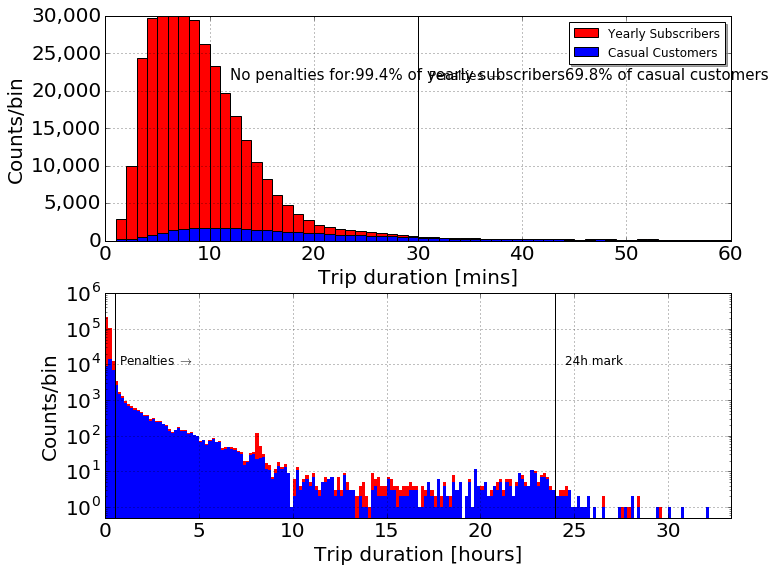

In [194]:
binw = 1
maxbin = 5000
bins = np.arange(0,maxbin,binw)
nn_subscribers,xx = np.histogram(duration_sec_subscribers/60.,bins=bins)
nn_customers,xx = np.histogram(duration_sec_customers/60.,bins=bins)

percent_non_penalty_subscribers = float(sum(nn_subscribers[np.where(xx<=30)]))/sum(nn_subscribers)*100
percent_non_penalty_customers = float(sum(nn_customers[np.where(xx<=30)]))/sum(nn_customers)*100
percent_string = r"No penalties for:%3.1f%% of yearly subscribers%3.1f%% of casual customers" % (percent_non_penalty_subscribers,percent_non_penalty_customers)
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=False,figsize=(10.,8.))
fig.tight_layout()

# Plot up to 1 hour
ax[0].bar(bins[:-1],nn_subscribers,color='r',bottom=nn_customers,width=binw,label='Yearly Subscribers')
ax[0].bar(bins[:-1],nn_customers,color='b',width=binw,label='Casual Customers')
ax[0].grid(1) # turn on grid
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlabel('Trip duration [mins]')
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,30000])
ax[0].plot((30,30),ax[0].get_ylim(),'-',color='k')
yloc = ax[0].get_ylim()[1]*0.72
ax[0].text(31,yloc,r"Penalties $\rightarrow$",color='k',fontsize=12)
ax[0].text(12,yloc,percent_string,fontsize=15)
FormatYAxisThousands(ax[0])
SetLegend(ax[0],'upper right')

binw2 = 10
maxbin2 = 2000
bins2 = np.arange(0,maxbin2,binw2)
nn_subscribers2,xx2 = np.histogram(duration_sec_subscribers/60.,bins=bins2)
nn_customers2,xx2 = np.histogram(duration_sec_customers/60.,bins=bins2)

# Plot long tail
ax[1].bar(bins2[:-1],nn_subscribers2,color='r',bottom=nn_customers2,width=binw2,label='Yearly Subscribers',linewidth=0)
ax[1].bar(bins2[:-1],nn_customers2,color='b',width=binw2,label='Casual Customers',linewidth=0)
ax[1].grid(1) # turn on grid
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlabel('Trip duration [hours]')
ax[1].set_xlim([0,maxbin2])
ax[1].set_ylim([0.5,1000000])
ax[1].set_yscale('log')
ax[1].plot((30,30),ax[1].get_ylim(),'-',color='k')
ax[1].text(45,10000,r"Penalties $\rightarrow$",color='k',fontsize=12)
ax[1].plot((24*60,24*60),ax[1].get_ylim(),'-',color='k')
ax[1].text(24.5*60,10000,r"24h mark",color='k',fontsize=12)
ax[1].set_xticks(range(0,maxbin2,300))
ax[1].set_xticklabels(np.array(ax[1].get_xticks())/60) # Relabel as hours
FormatYAxisThousands(ax[0])
SetLegend(ax[0],'upper right')

plt.show()

## Look at the Individual Bicycle Usage

In [36]:
t.tic()
start_unixtime = 1377792480; # This is the first time entry. Use for 'days since' calculation

query_bikes = "select a.bike_num, \
                count(*) as total, \
                b.landmark_code \
                from trip_data a \
                inner join station_data b \
                on a.start_terminal = b.station_id \
                group by a.bike_num;"

results = db.query(query_bikes)
t.toc()

# [0] bike_num
# [1] count
# [2] landmark_code

bikes_roster = np.array([x[0] for x in results])
trip_count = np.array([x[1] for x in results])
location = np.array([x[2] for x in results])
index_sf = location == 'SF' # which bikes are in SF

num_bikes = len(bikes_roster) # Total number of distinct bikes
print '%d distinct bikes' % num_bikes

# sort the bikes by use, descending
I = np.argsort(trip_count)
bikes_roster_sorted = bikes_roster[I]

bike_xaxis = np.arange(0,len(trip_count)) # Let's just use linear values here, no bike ID
trip_count_sorted = trip_count[I]
index_sf_sorted = index_sf[I]

Time elapsed: 0.40 sec
668 distinct bikes


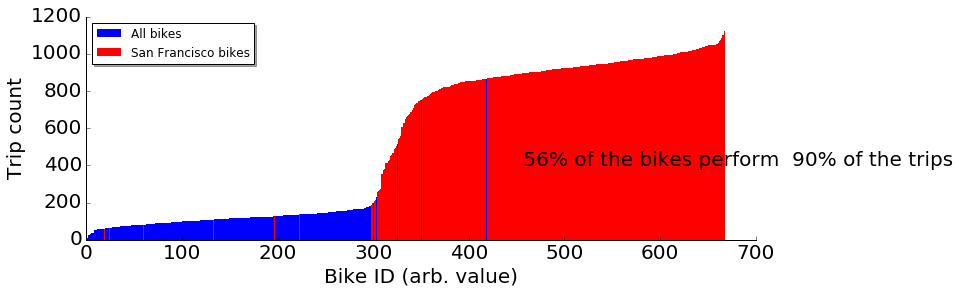

In [38]:
fig = plt.figure(figsize = (12.,4.))
ax = fig.gca()
ax.bar(bike_xaxis,trip_count_sorted,color='b',width=1,linewidth=0,label='All bikes')
ax.bar(bike_xaxis[index_sf_sorted],trip_count_sorted[index_sf_sorted],color='r',width=1,linewidth=0,label='San Francisco bikes')
sf_percent_total_bikes = float(sum(index_sf_sorted))/len(index_sf_sorted)*100
sf_percent_total_usage = float(sum(trip_count_sorted[index_sf_sorted]))/sum(trip_count_sorted)*100
ax.text(450,400,r'%3.0f%% of the bikes perform %3.0f%% of the trips' % (sf_percent_total_bikes,sf_percent_total_usage))
ax.set_xlabel('Bike ID (arb. value)')
ax.set_ylabel('Trip count')
SetLegend(ax,'upper left')
RemoveBorder(ax)
plt.show()

### Bicycle Lifetime

In [63]:
t.tic()
start_unixtime = 1409270400;

query_bikes = "select floor((unix_timestamp(start_date)-%d)/86400/7) as weeks_since, \
                bike_num, \
                count(*) \
                from trip_data \
                group by weeks_since, bike_num;" % start_unixtime;

results = db.query(query_bikes)
t.toc()

# [0] days_since
# [1] bike_num
# [2] count

# Now we need to build the matrix
bikes_roster = list(np.unique([x[1] for x in results]))

num_bikes = len(bikes_roster) # Total number of distinct bikes
num_weeks = results[-1][0]+1 # It's in increasing order of days_since, so last entry+1 is max

Time elapsed: 0.68 sec


In [64]:
# Now put it all into a matrix that we can visualize with plt.pcolor

t.tic()
# Initialize bike matrix
bike_matrix = np.zeros((num_bikes,num_weeks))
maxval = max([x[2] for x in results])

# Populate matrix
for x in results:
    bindex = bikes_roster.index(x[1])
    bike_matrix[bindex,x[0]] = x[2]
t.toc()

Time elapsed: 1.12 sec


In [65]:
# Make a binary mask of the matrix. 1 means the bike had a trip that week. 0 means did not.
# Only copy the bikes in San Francisco into the masked matrix since those are the ones
# we care about for this analysis.

t.tic()
bike_matrix_binary = np.copy(bike_matrix[index_sf,:])
bike_matrix_binary[bike_matrix_binary > 0] = 1
n_bikes,n_weeks = shape(bike_matrix_binary)
bikes_roster_sf = np.array(bikes_roster)[index_sf]

# Compute for each bike the % of the weeks it was live
bike_live_fraction = np.array(sum(bike_matrix_binary,1))/float(n_weeks)

bike_lifetime = []
unusable_bike_id = []

# Now we will assign a value of 2 for the start of the bike use, and 3 for the last used week
for jj in xrange(n_bikes):
    bike_start = find(bike_matrix_binary[jj,:] > 0)[0]
    bike_end = find(bike_matrix_binary[jj,:] > 0)[-1]
    bike_matrix_binary[jj,bike_start] = -1
    bike_matrix_binary[jj,bike_end] = 2
    
    # Find which bikes have not been used for at least 4 weeks by the end of the data series
    # First reverse the week timeline
    week_timeline_reverse = np.array(bike_matrix_binary[jj,::-1])
    # Do cumulative sum
    use_cumsum = np.cumsum(week_timeline_reverse)
    # If the first nonzero entry in the cumulative sum is 4 weeks or more, save how many days it was used for
    if find(use_cumsum > 0)[0] >= 3: #3 is 4th week since it starts at 0
        bike_lifetime.append(sum(week_timeline_reverse))
        unusable_bike_id.append(bikes_roster_sf[jj])
    
bike_lifetime = np.array(bike_lifetime)
unusable_bike_id = np.array(unusable_bike_id)
t.toc()

Time elapsed: 0.01 sec


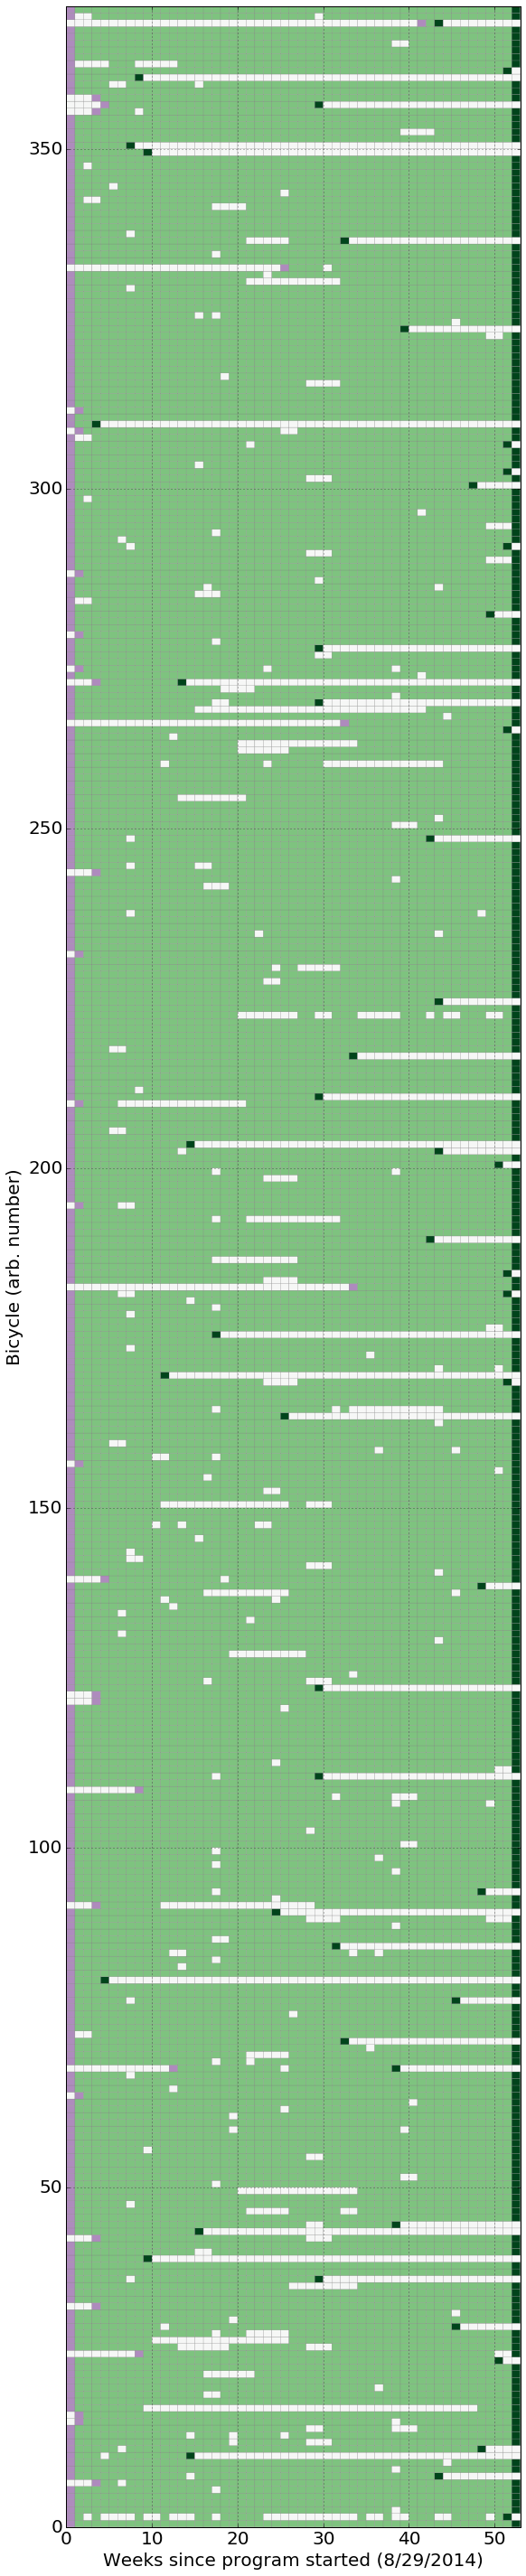

In [66]:
fig = plt.figure(figsize = (9,50))
ax = fig.gca()
xx = np.linspace(0,n_weeks,n_weeks+1)
yy = np.linspace(0,n_bikes,n_bikes+1)
cax = ax.pcolor(xx,yy,bike_matrix_binary,cmap=plt.get_cmap('PRGn'),vmin=-2,vmax=2,alpha=1, edgecolors=(0.5,0.5,0.5))
ax.grid(1)
ax.set_xlabel('Weeks since program started (8/29/2014)')
ax.set_ylabel('Bicycle (arb. number)')
ax.set_xlim([0,num_weeks])
ax.set_ylim([0,sum(index_sf)]);

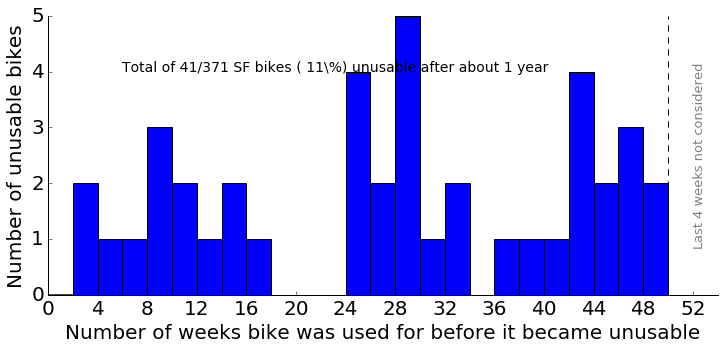

In [67]:
fig = plt.figure(figsize = (12.,5.))
ax = fig.gca()
ax.hist(bike_lifetime,bins=np.arange(0,54,2))
ax.set_xlim([0,54])
ax.set_xlabel('Number of weeks bike was used for before it became unusable')
ax.set_ylabel('Number of unusable bikes')
ax.text(6,4,r'Total of %d/%d SF bikes (%3.0f\%%) unusable after about 1 year' % (len(bike_lifetime),n_bikes,len(bike_lifetime)/float(n_bikes)*100),fontsize=14)
ax.text(52,4,'Last 4 weeks not considered',rotation=90,fontsize=13,color='gray')
ax.plot((50,50),ax.get_ylim(),'k--')
ax.set_xticks(np.arange(0,54,4));
RemoveBorder(ax)
plt.show()

### Inspect the bikes that became unusable a bit closer


In [68]:
print unusable_bike_id

[ 85  97 100 265 273 276 280 281 319 324 330 333 339 345 349 367 381 398
 424 430 438 452 466 467 474 481 490 515 536 539 545 551 571 580 596 610
 626 627 633 637 740]


In [71]:
# Get the last trip information for these bikes and see if there are any clusters
# This could be done in a really nasty MySQL command, but I find it simpler to it in a
# Python loop, once for each bike, and populate arrays. It's only 17 secs anyways
# for this amount of data

t.tic()

dates = []
duration_min = []
start_terminal = []
start_station = []
end_terminal = []
end_station = []
subscription_type = []

for bike_num in unusable_bike_id:
    query = "select start_date, \
                duration_sec/60 as duration_min, \
                start_terminal, \
                start_station,\
                end_terminal, \
                end_station,\
                subscription_type \
                from trip_data \
                where bike_num=%d \
                order by start_date desc limit 1;" % bike_num

    results = db.query(query)
    dates.append(results[0][0])
    duration_min.append(results[0][1])
    start_terminal.append(results[0][2])
    start_station.append(results[0][3])
    end_terminal.append(results[0][4])
    end_station.append(results[0][5])
    subscription_type.append(results[0][6])
t.toc()

Time elapsed: 6.81 sec


In [72]:
print "%d/%d of unusable bikes were last ridden by a Subscriber" % (sum(np.array(subscription_type) == 'Subscriber'),len(subscription_type))
print "%d/%d of unusable bikes were last ridden by a Customer" % (sum(np.array(subscription_type) == 'Customer'),len(subscription_type))

36/41 of unusable bikes were last ridden by a Subscriber
5/41 of unusable bikes were last ridden by a Customer


In [73]:
# Get the names of the corresponding station numbers to use in plot.
# Do this for both start and stop terminals
# Use np.unique to return a sorted unique list of station numbers.
# Then apply the sort index to the names list
# (unfortunately need a for loop since cannot be indexed with vector)

def SortTextArray(arr,I):
    output_ar = []
    for i in I:
        output_ar.append(arr[i])
    return output_ar

# start
start_terminals_unique,I = np.unique(start_terminal,return_index=True)
start_labels = SortTextArray(start_station,I)

# end
end_terminals_unique,I = np.unique(end_terminal,return_index=True)
end_labels = SortTextArray(end_station,I)

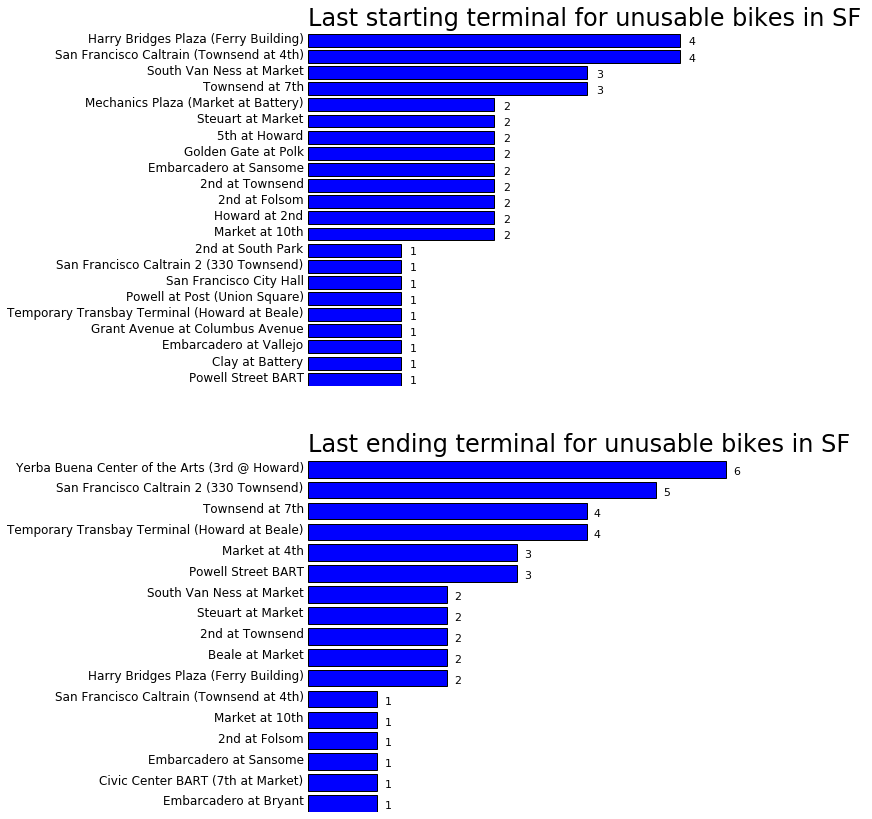

In [74]:
def PlotBarHClean(values,labels,ax=None):
    '''
        Labels must be in ascending order of unique 'values'
    '''
    ax = ax or plt.gca()
    nn,xx = np.histogram(values,bins=np.unique(values));
    I = np.argsort(nn)
    nns = nn[I]
    xxs = xx[I]
    pos = np.arange(len(nn))
    # Make a horizontal bar graph
    ax.barh(pos,nns)
    # add the numbers to the side of each bar
    for p, c, ch in zip(pos, start_labels, nns):
        ax.annotate(str(ch), xy=(ch+0.1, p+0.3), va='center',fontsize=11)
    # cutomize ticks
    ax.set_yticks(pos + .5)
    ax.set_yticklabels(SortTextArray(labels,I),fontsize=12)
    xt = ax.get_xticks()
    ax.set_xticks(xt, [' '] * len(xt))
    ax.tick_params(labelbottom='off')
    ax.set_xlim([0,max(nn)+2])
    ax.set_ylim([0,max(pos)+1])
    RemoveBorder(ax,left=False, bottom=False)

fig,ax = plt.subplots(nrows=2,ncols=1,sharex=False,figsize=(10.,14.))
# fig.tight_layout()
PlotBarHClean(start_terminal,start_labels,ax[0]);
ax[0].set_title('Last starting terminal for unusable bikes in SF',loc='left')
PlotBarHClean(end_terminal,end_labels,ax[1])
ax[1].set_title('Last ending terminal for unusable bikes in SF',loc='left')
plt.show()

### Stations Full and Depleted


In [75]:
t.tic()
# Make a dictionary with {station_id:name} for stations
stations = db.query("select station_id,concat(name,' [',landmark_code,']') from station_data;")
stations_dict = dict([(x[0],x[1]) for x in stations])
stations_num = stations_dict.keys()
station_names = stations_dict.values()

start_unixtime = 1377792480;
query_str_bikes = "select a.station_id, \
            floor((unix_timestamp(time)-%d)/86400) as days_since, \
            count(*) \
            from rebalancing_data a \
            inner join station_data b \
            on a.station_id=b.station_id \
            where a.bikes_available=0 \
            group by days_since,a.station_id;" % start_unixtime 

results = db.query(query_str_bikes)

query_str_docks = "select a.station_id, \
            floor((unix_timestamp(time)-%d)/86400) as days_since, \
            count(*) \
            from rebalancing_data a \
            inner join station_data b \
            on a.station_id=b.station_id \
            where a.docks_available=0 \
            group by days_since,a.station_id;" % start_unixtime 

results_docks = db.query(query_str_docks)
t.toc()

# [0] station_id
# [1] days_since
# [2] count

num_stations = len(stations_dict) # Total number of distinct bikes.
num_days = results[-1][1]+1 # It's in increasing order of days_since, so last entry+1 is max

Time elapsed: 26.93 sec


In [76]:
# Put the data into a matrix so we can visualize it as an image in plt.pcolor

t.tic()
station_matrix = np.zeros((num_stations,num_days))

maxval1 = max([x[2] for x in results])
maxval2 = max([x[2] for x in results_docks])
maxval = max([maxval1,maxval2])

# Populate matrix
for x in results:
    station_matrix[stations_num.index(x[0]),x[1]] = x[2]

station_matrix_docks = np.zeros((num_stations,num_days))
for x in results_docks:
    station_matrix_docks[stations_num.index(x[0]),x[1]] = x[2]
    
station_matrix = station_matrix-station_matrix_docks
t.toc()

Time elapsed: 0.03 sec


Time elapsed: 1.57 sec


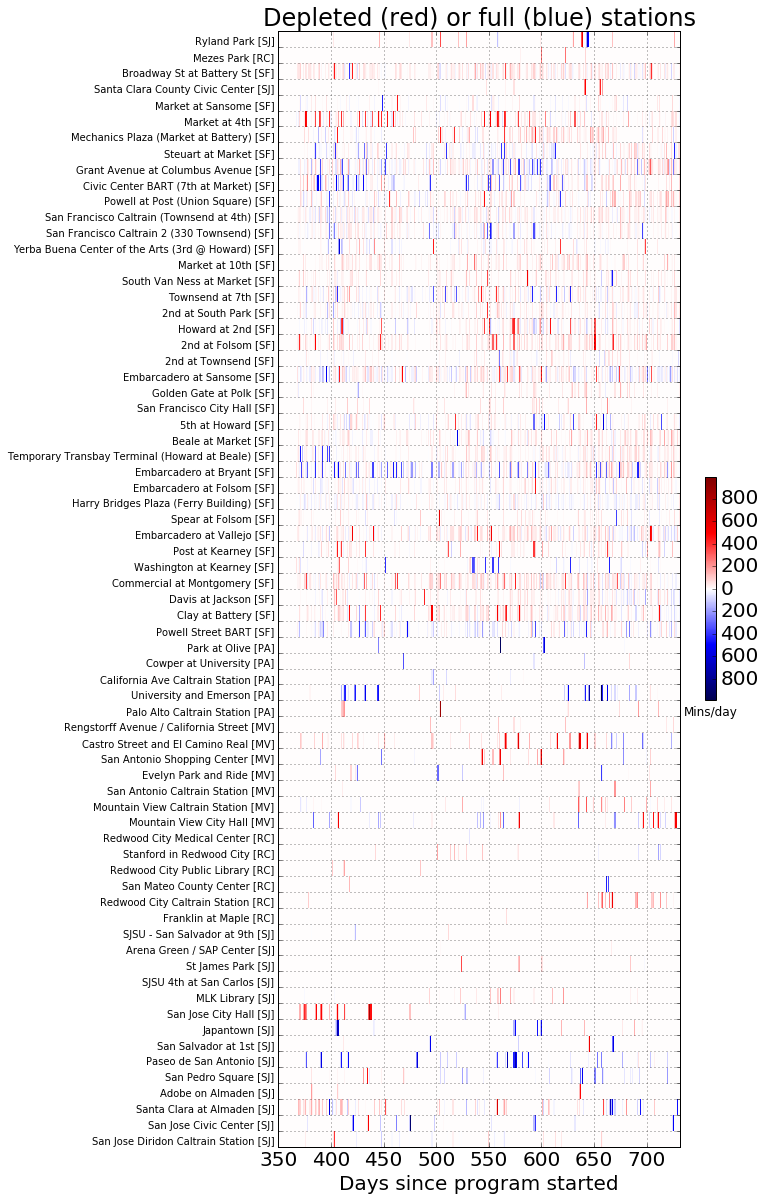

In [78]:
t.tic()
fig = plt.figure(figsize = (9,20))
ax = fig.gca()
cax = ax.pcolor(np.linspace(0,num_days,num_days+1),np.linspace(0,num_stations,num_stations+1),station_matrix,cmap=plt.get_cmap('seismic'),vmin=-maxval,vmax=maxval)
ax.set_xlabel('Days since program started')
ax.set_xlim([350,num_days])
ax.set_ylim([0,num_stations])
ax.set_yticks(np.linspace(0,num_stations-1,num_stations))
ax.set_yticklabels(station_names,va='bottom',fontsize=10)
ax.grid(1)
ax.set_title('Depleted (red) or full (blue) stations')
cbar = fig.colorbar(cax,shrink=0.2)
cbar.ax.set_xlabel('Mins/day',fontsize=12);
cbar.ax.set_yticklabels(['800','600','400','200','0','200','400','600','800'])# vertically oriented colorbar
t.toc()